# Reading a SACC file with CMB and LSS data
This example shows how to read LSS and CMB-like data from a SACC file. You should run the `CMB_LSS_write` notebook before this one in order to have some data to read!

In [1]:
import sacc
import numpy as np
import matplotlib.pyplot as plt

## Reading the data
This is as simple as:

In [2]:
s = sacc.Sacc.load_fits('cmblss.fits')

/home/alonso/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Inspecting the contents
Let's now understand the contents of this file.

### Tracers
First, let's see what quantities have been correlated

In [3]:
for n, t in s.tracers.items():
    print(t.name, t.quantity, type(t))

ck cmb_convergence <class 'sacc.tracers.MapTracer'>
B20_T cmb_temperature <class 'sacc.tracers.NuMapTracer'>
B20_P cmb_polarization <class 'sacc.tracers.NuMapTracer'>
gc galaxy_density <class 'sacc.tracers.NZTracer'>
wl galaxy_shear <class 'sacc.tracers.NZTracer'>


OK, so there is a CMB lensing tracer (as a `Map` tracer), a galaxy clustering tracer and a cosmic shear tracer (as `NZ` tracers), and the temperature and polarization of a given frequency map (as two `NuMap` tracers).

Let's look at the redshift distributions, bandpasses and beams.

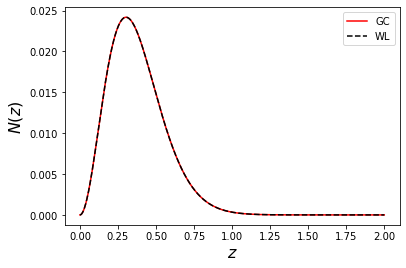

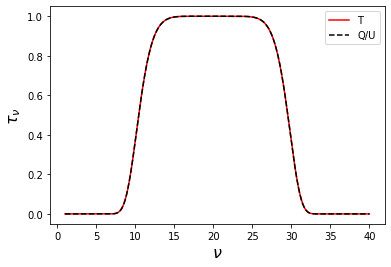

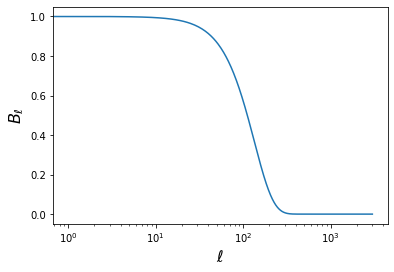

In [4]:
# N(z)
plt.figure()
plt.plot(s.tracers['gc'].z, s.tracers['gc'].nz, 'r-', label='GC')
plt.plot(s.tracers['wl'].z, s.tracers['wl'].nz, 'k--', label='WL')
plt.xlabel('$z$', fontsize=16)
plt.ylabel('$N(z)$', fontsize=16)
plt.legend(loc='upper right')

# Bandpass
plt.figure()
plt.plot(s.tracers['B20_T'].nu, s.tracers['B20_T'].bandpass, 'r-', label='T')
plt.plot(s.tracers['B20_P'].nu, s.tracers['B20_P'].bandpass, 'k--', label='Q/U')
plt.xlabel(r'$\nu$', fontsize=16)
plt.ylabel(r'$\tau_\nu$', fontsize=16)
plt.legend(loc='upper right')

# Beam
plt.figure()
plt.plot(s.tracers['B20_T'].ell, s.tracers['B20_T'].beam)
plt.xscale('log')
plt.xlabel(r'$\ell$', fontsize=16)
plt.ylabel(r'$B_\ell$', fontsize=16)
plt.show()

### Power spectra
Let's find out which two-point functions are included


In [5]:
# Type of power spectra
data_types = np.unique([d.data_type for d in s.data])
print("Data types: ", data_types)

# Tracer combinations
print("Tracer combinations: ", s.get_tracer_combinations())

# Data size
print("Size: ", s.mean.size)


Data types:  ['cl_00' 'cl_0b' 'cl_0e' 'cl_bb' 'cl_be' 'cl_eb' 'cl_ee']
Tracer combinations:  [('B20_T', 'B20_T'), ('ck', 'B20_T'), ('ck', 'ck'), ('gc', 'B20_T'), ('gc', 'ck'), ('gc', 'gc'), ('B20_T', 'B20_P'), ('ck', 'B20_P'), ('gc', 'B20_P'), ('gc', 'wl'), ('wl', 'B20_T'), ('wl', 'ck'), ('B20_P', 'B20_P'), ('wl', 'B20_P'), ('wl', 'wl')]
Size:  2800


## Cutting the data
Let's remove anything that we don't care about.

First let's say we're not interested in any B-mode data

In [6]:
print(s.mean.size)
s.remove_selection(data_type='cl_eb')
s.remove_selection(data_type='cl_be')
s.remove_selection(data_type='cl_bb')
s.remove_selection(data_type='cl_0b')
print(s.mean.size)

2800
1500


Now let's ignore all power spectra involving the `B20_P` tracer, and also all cross-correlations with `B20_T`.

In [7]:
s.get_tracer_combinations()
for t in s.tracers:
    s.remove_selection(tracers=('B20_P', t))
    s.remove_selection(tracers=(t, 'B20_P'))
    if t!='B20_T':
        s.remove_selection(tracers=('B20_T', t))
        s.remove_selection(tracers=(t, 'B20_T'))
        
s.get_tracer_combinations()

/home/alonso/.local/lib/python3.6/site-packages/sacc-0.2.3-py3.6.egg/sacc/sacc.py:368: UserWarning: Empty index selected - maybe you should check the tracer order?


[('B20_T', 'B20_T'),
 ('ck', 'ck'),
 ('gc', 'ck'),
 ('gc', 'gc'),
 ('gc', 'wl'),
 ('wl', 'ck'),
 ('wl', 'wl')]

Finally, let's impose some scale cuts. 
Since small-scale clustering is tricky, let's remove all ells > 100 for any power spectrum involving `gc`.

In [8]:
print(s.mean.size)
for t in s.tracers:
    s.remove_selection(tracers=('gc', t), ell__gt=100)
    s.remove_selection(tracers=(t, 'gc'), ell__gt=100)
print(s.mean.size)

700
430


/home/alonso/.local/lib/python3.6/site-packages/sacc-0.2.3-py3.6.egg/sacc/sacc.py:368: UserWarning: Empty index selected - maybe you should check the tracer order?


The full covariance matrix and data vector can be obtained through `Sacc.covariance.covmat` and `Sacc.mean` respectively.

In [9]:
print(s.covariance.covmat.shape,s.mean.shape)

(430, 430) (430,)


## Bandpower window functions
Let's now access bandpower window functions. To do this, we first need to get the indices corresponding to a given power spectrum and then use `get_bandpower_windows`.

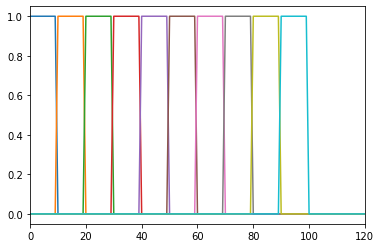

In [12]:
# Get spectra
l, cl_gg, cov_gg, ind_gg = s.get_ell_cl('cl_00', 'gc', 'gc', return_cov=True, return_ind=True)
# Query windows from indices
bpw = s.get_bandpower_windows(ind_gg)

# Let's plot them!
plt.figure()
for w in bpw.weight.T:
    plt.plot(bpw.values, w)
plt.xlim([0, 120]);

## Plotting the data
We can now do stuff with the contents of the SACC file

Let's plot all power spectra with their error bars.

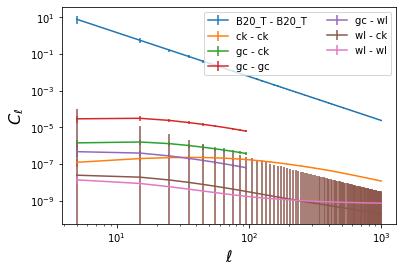

In [13]:
plt.figure()
for t1, t2 in s.get_tracer_combinations():
    l, cl, cov = s.get_ell_cl(None, t1, t2, return_cov=True)
    err = np.sqrt(np.diag(cov))
    plt.errorbar(l, cl, err, label='%s - %s' % (t1, t2))
plt.loglog()
plt.legend(ncol=2)
plt.xlabel(r'$\ell$',fontsize=16)
plt.ylabel(r'$C_\ell$',fontsize=16)
plt.show()